## <font color='green'>Section 1: Business understanding</font>
- <font color='darkorange'>Question 1 - At what types of companies do developers get paid the most?</font>
- <font color='darkorange'>Question 2 - How does programming experience affect pay at different types of companies?</font>
- <font color='darkorange'>Question 3 - Does the ability to work remotely impact job satisfaction and salary?</font>

#### Import libraries
If there are any libraries below that you haven't yet installed, just use `!pip install` to install the necessary libraries

In [1]:
import io
import zipfile
import requests
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_blog_functions as pbf # Python file that contains the user-defined function for creating the heatmap in this notebook
%matplotlib inline

#### Download data programatically

In [74]:
url =  'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2017.zip'
path="./" + url.split("/")[-1].split(".")[0]

# Use the requests library to make the connection to the url
r = requests.get(url)

# Extract the contents from the downloaded zipfile
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=path)

## <font color='green'>Section 2: Data Understanding</font>

#### Read in the files

In [2]:
working_dir = os.getcwd()

public_file = [] # The path location for the survey data will be stored in this list

for root, dirs, files in os.walk(working_dir):
    files = glob.glob(os.path.join(root, '*public.csv'))
    for f in files:
        public_file.append(f)

schema_file = [] # The path location for the schema data will be stored in this list

for root, dirs, files in os.walk(working_dir):
    files = glob.glob(os.path.join(root, '*schema.csv'))
    for f in files:
        schema_file.append(f)

In [3]:
pd.options.display.max_colwidth = None # Changing default dataframe column width so we can see the entire Question column

In [4]:
schema = pd.read_csv(schema_file[0]) # Read in the schema data
schema.head()

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to open source projects?
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree-granting college or university program?"


In [5]:
pd.options.display.max_columns = None # Changing the default dataframe columns shown so that we can see al of them

In [6]:
survey = pd.read_csv(public_file[0]) # Read in the survey data
survey.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new opportunities",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stack Overflow,9.0,Deskto

In [99]:
#pd.options.display.max_rows = 10

## <font color='green'>Section 3: Data Preparation</font>

#### Check for missing values in the schema dataframe

In [7]:
schema.isnull().sum()

Column      0
Question    0
dtype: int64

In [8]:
schema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Column    154 non-null    object
 1   Question  154 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [9]:
schema.shape

(154, 2)

We can confirm that there are no missing values in the schema dataframe

#### Check for missing values in the columns of interest in the survey dataframe

Below are the columns of interest

In [10]:
columns_of_interest = ['CompanyType', 'YearsProgram', 'JobSatisfaction', 'HomeRemote', 'Salary']

In [11]:
# Checking for any missing values in the columns of interest
survey[columns_of_interest].isnull().sum()

CompanyType        12569
YearsProgram         247
JobSatisfaction    11016
HomeRemote          7384
Salary             38501
dtype: int64

Almost 25% of the company type values are missing. We will drop the missing values as we need this value to determine which types of companies pay the most to answer Question 1.

In [12]:
survey.CompanyType.isnull().sum() / survey.shape[0] * 100

24.45711394769614

Almost 75% of the salaries are missing. Filling this many values with the either the mean, median or mode would cause disruption in the proportion of the data, so we will drop these missing values.

In [13]:
survey.Salary.isnull().sum() / survey.shape[0] * 100

74.91632938978829

#### Dropping the rows with missing values in the CompanyType or Salary columns

In [14]:
survey = survey.dropna(subset=['CompanyType', 'Salary']).reset_index(drop=True)

In [15]:
# Check to see if it worked
survey[columns_of_interest].isnull().sum()

CompanyType         0
YearsProgram       11
JobSatisfaction    37
HomeRemote          4
Salary              0
dtype: int64

#### For the remaining missing values
- we will fill the  Jobsatisfaction missing values with the mean value
- we will fill the YearsProgram, HomeRemote missing values with the mode

In [18]:
# Imputing the JobSatisfaction missing values with the mean
survey.JobSatisfaction.fillna(survey.JobSatisfaction.mean(), inplace=True)

In [27]:
# Imputing the YearsProgram and HomeRemote missing values with the mode
survey.YearsProgram.fillna(survey.YearsProgram.mode()[0], inplace=True)

survey.HomeRemote.fillna(survey.HomeRemote.mode()[0], inplace=True)

In [28]:
# Check if we have successfully removed the missing values from the columns of interest
survey[columns_of_interest].isnull().sum()

CompanyType        0
YearsProgram       0
JobSatisfaction    0
HomeRemote         0
Salary             0
dtype: int64

## <font color='green'>Section 4: Evalute Results</font>

#### <font color='darkorange'>Question 1 - At what types of companies do developers get paid the most?</font>

In [29]:
sns.set_theme() # To use seaborn theme

C:\Users\moche\AppData\Local\Temp\ipykernel_176068\3616866906.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]); # Formatting the y axis so that thousands are shown with a comma separator


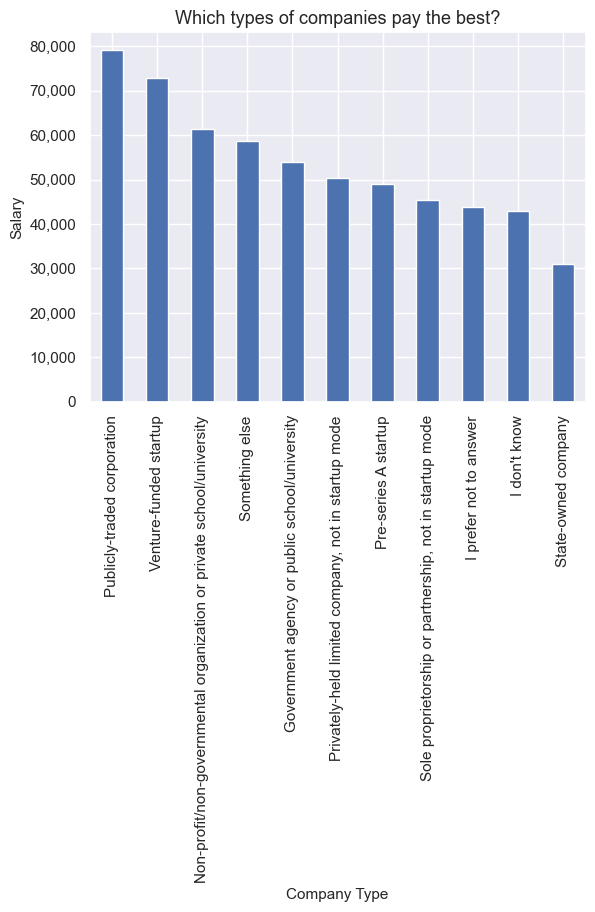

In [30]:
# Groupby the CompanyType column and get the average salary for each company type. Then sort these salaries in descending order and plot as a column chart.
survey.groupby('CompanyType').mean()['Salary'].sort_values(ascending=False).plot(kind='bar')
# Chart formatting
plt.title('Which types of companies pay the best?', fontsize=13)
plt.ylabel('Salary', fontsize=11)
plt.yticks(fontsize = 11)
plt.xlabel('Company Type', fontsize=11)
plt.xticks(fontsize = 11)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]); # Formatting the y axis so that thousands are shown with a comma separator

*We can see in descending order the average salaries for the types of companies in the survey.*

**Key points:**
- Publicly-traded corporations and venture-funded startups pay the best on average (79k and 73k respectively)
- This is more than double of what the employees receive at state-owned companies (31k)

#### <font color='darkorange'>Question 2 - How does programming experience affect pay at different types of companies?</font>

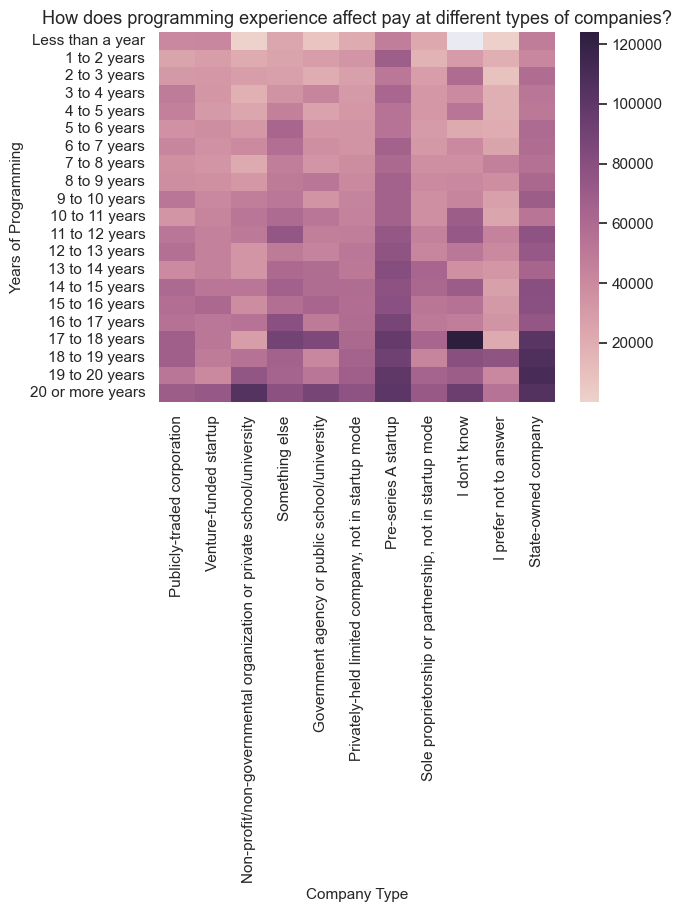

In [32]:
pbf.create_heatmap(survey) # Create the Salary heatmap with Years of Programming on the y axis and Company Type on the x axis

*We can see a heatmap showing the average salaries for the types of companies and the amount of programming experience.*

*The darker the data point, the higher the salary — i.e. people who answered ‘I don’t know for company type’ with 17–18 years of programming experience tend to receive the highest average salaries.*

**Key points:**
- In general, the more programming experience you have, the more you get paid. This trend is true across all company types.
- But the difference in average salaries depending on experience varies by company type.
- For publicly-traded corporations and venture-funded start-ups, the salary difference between employees with more years of programming experience and employees with fewer years of programming is significantly less than for pre-series A start-ups or state-owned companies.
- Employees with 17+ years of programming experience at state-owned companies make much more than their peers at publicly traded corporations or venture-funded startups with the same amount of programming experience. (This is despite the fact that publicly traded corporations and venture-funded startups on average pay over twice as much as state-owned companies.)

#### <font color='darkorange'>Question 3 - Does the ability to work remotely impact job satisfaction and salary?</font>

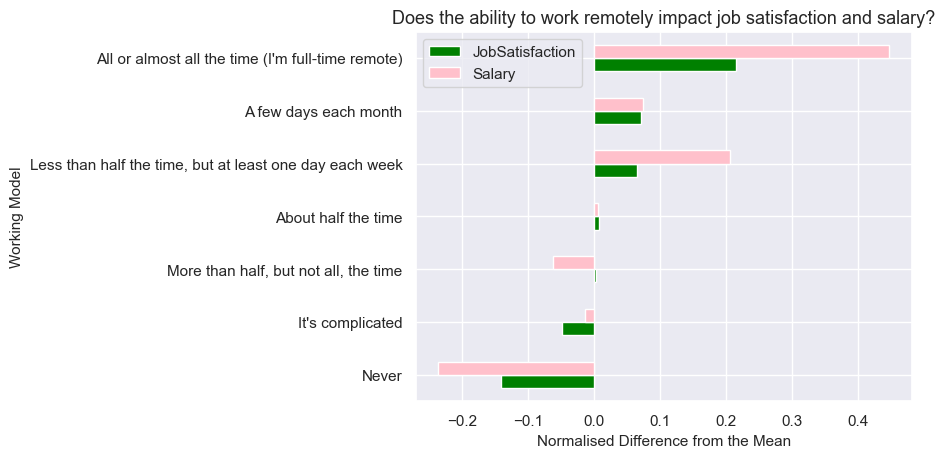

In [33]:
# Get the normalised difference from the mean for both Salary and JobSatisfaction

avg_job_sat = survey.JobSatisfaction.mean()
std_job_sat = survey.JobSatisfaction.std()

avg_sal = survey.Salary.mean()
std_sal = survey.Salary.std()

sat_sal_df = survey.groupby('HomeRemote').mean()[['JobSatisfaction','Salary']]
sat_sal_df.columns = ['AvgJobSatisfaction', 'AvgSalary']

sat_sal_df['JobSatisfaction'] = (sat_sal_df.AvgJobSatisfaction - avg_job_sat) / std_job_sat
sat_sal_df['Salary'] = (sat_sal_df.AvgSalary - avg_sal) / std_sal

# Plot the normalised difference from the mean as horizontal bar charts
ax = sat_sal_df.sort_values('JobSatisfaction', ascending=True)[['JobSatisfaction', 'Salary']].plot.barh(color = ['green', 'pink'])
# Chart formatting
plt.title('Does the ability to work remotely impact job satisfaction and salary?', fontsize=13)
plt.ylabel('Working Model', fontsize=11)
plt.yticks(fontsize = 11)
plt.xlabel('Normalised Difference from the Mean', fontsize=11)
plt.xticks(fontsize = 11);

*The green bar chart compares the working model group average job satisfaction to the average job satisfaction of all survey participants, which is shown at 0.0.*

*The pink bar chart compares the working model group average salary to the average salary of the entire dataset, which is again, shown at 0.0.*

**Key Points:**
- We can clearly see that employees who work remotely all or almost all of the times are much happier than the average, and also make much more money than the average developer.
- We can clearly see that employees who are office-based all the times make less money and are much less satisfied with their jobs than the average.